In [1]:
import zipfile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('raw_data.csv')

In [3]:
Q1 = 'How many hours on average do you currently review code per week?'
Q2 = 'Do you expect to spend more, less, or same time for code review in five years (in comparison to today)?'
Q3 = 'What software artifacts do you review today?'
Q4 = 'What software artifacts do you anticipate to review in five years?'

Load Stackoverflow Survey data from 2019 as reference

In [4]:
with zipfile.ZipFile('stack-overflow-developer-survey-2019.zip') as z:
    with z.open('survey_results_public.csv') as file:
        stackoverflow_survey = pd.read_csv(file, usecols=['CodeRevHrs']).dropna()
stackoverflow_survey.shape[0]

49790

In [5]:
microsoft = pd.Series([0, 0.26, 0.48, 0.21], index=[0, 2, 5, 10], name='microsoft')
microsoft

0     0.00
2     0.26
5     0.48
10    0.21
Name: microsoft, dtype: float64

In [6]:
microsoft_cdf = microsoft.cumsum()
stackoverflow_cdf = stackoverflow_survey.CodeRevHrs.value_counts(normalize=True, dropna=True).sort_index().cumsum()
df_cdf = df[Q1].value_counts(normalize=True).sort_index().cumsum()

(0.0, 10.0)

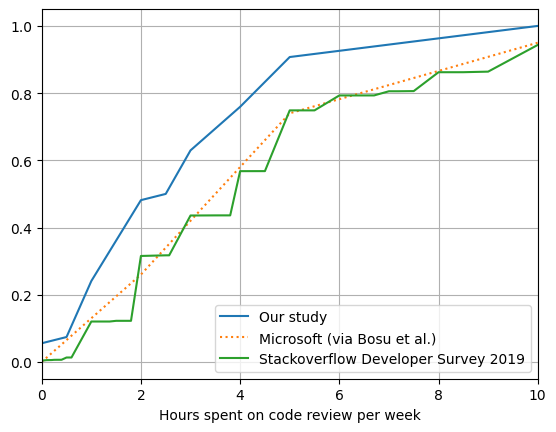

In [7]:
fig, ax = plt.subplots()

df_cdf.plot(label='Our study', ax=ax)
microsoft_cdf.plot(linestyle='dotted', label='Microsoft (via Bosu et al.)', ax=ax)
stackoverflow_cdf.plot(label='Stackoverflow Developer Survey 2019', ax=ax)

ax.set_xlabel('Hours spent on code review per week')
ax.legend(loc='lower right')
ax.grid('both')
ax.set_xlim((0, 10))


In [8]:
df_cdf.to_csv('Q1.csv', header=False)

In [9]:
df[Q2].value_counts(normalize=True).apply(lambda x: f'\\SI{{{x * 100:.2f}}}{{\\percent}}')

Do you expect to spend more, less, or same time for code review in five years (in comparison to today)?
More time on code review         \SI{41.82}{\percent}
About the same on code review    \SI{30.91}{\percent}
Less time on code review         \SI{27.27}{\percent}
Name: proportion, dtype: object

The folling needs some love and more beauty :) Let us use categorical data so that "POC code" and "ci code" shows up in the category "others". I also would prefer a different visualization.

In [10]:
s = df[Q3].str.split(';').explode()
p1 = s[s != ''].rename('artifact').to_frame().reset_index(names='participant').groupby('artifact').participant.nunique().sort_values().rename('Today')

In [11]:
s = df[Q4].str.split(';').explode()
p2 = s[s != ''].rename('artifact').to_frame().reset_index(names='participant').groupby('artifact').participant.nunique().sort_values().rename('Tomorrow')

In [12]:
print((pd.concat([p1, p2], axis=1) / len(df[Q3].index) * 100.0).reindex(['Production code', 'Test code', 'Parameter/configuration files', 'Documentation', 'GUI-based test code (end-to-end testing)', 'None', 'POC code', 'ci code']).to_latex(float_format='\\SI{{{:.2f}}}{{\\percent}}'.format))

\begin{tabular}{lrr}
\toprule
 & Today & Tomorrow \\
artifact &  &  \\
\midrule
Production code & \SI{76.36}{\percent} & \SI{81.82}{\percent} \\
Test code & \SI{60.00}{\percent} & \SI{63.64}{\percent} \\
Parameter/configuration files & \SI{60.00}{\percent} & \SI{67.27}{\percent} \\
Documentation & \SI{60.00}{\percent} & \SI{67.27}{\percent} \\
GUI-based test code (end-to-end testing) & \SI{21.82}{\percent} & \SI{30.91}{\percent} \\
None & \SI{9.09}{\percent} & \SI{3.64}{\percent} \\
POC code & \SI{1.82}{\percent} & NaN \\
ci code & NaN & \SI{1.82}{\percent} \\
\bottomrule
\end{tabular}

